In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import vrpSolver

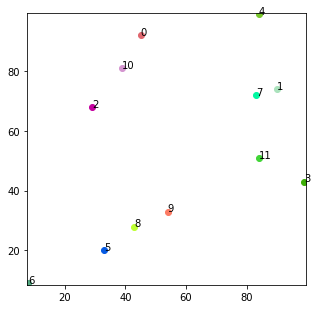

In [2]:
# Generate instance
nodes = vrpSolver.rndPlainNodes(N = 12)
fig, ax = vrpSolver.plotNodes(
    nodes = nodes)

In [3]:
# DFJ with lazy cut
DFJ_Lazy = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "DFJ_Lazy",
    timeLimit = 300)
print(DFJ_Lazy)

Academic license - for non-commercial use only
{'ofv': 300.4941258104151, 'seq': [0, 10, 2, 6, 5, 8, 9, 3, 11, 7, 1, 4, 0], 'gap': 0, 'lowerBound': 300.4941258104151, 'upperBound': 300.4941258104151, 'runtime': 0.0029811859130859375, 'fml': 'DFJ_Lazy'}


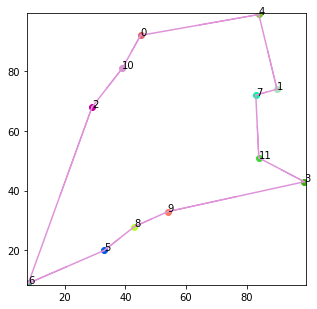

In [4]:
# Plot the result of TSP
vrpSolver.plotSeq(
    fig = fig,
    ax = ax,
    nodes=nodes, 
    seq=DFJ_Lazy['seq'])
fig

In [5]:
# DFJ with plain loop
DFJ_PlainLoop = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "DFJ_PlainLoop",
    timeLimit = 300)
print(DFJ_PlainLoop)

{'ofv': 300.4941258104151, 'seq': [0, 10, 2, 6, 5, 8, 9, 3, 11, 7, 1, 4, 0], 'gap': 0, 'lowerBound': 300.4941258104151, 'upperBound': 300.4941258104151, 'runtime': 0.0030002593994140625, 'fml': 'DFJ_PlainLoop'}


In [6]:
# MTZ
MTZ = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "MTZ",
    timeLimit = 300)
print(MTZ)

{'ofv': 300.4941258104151, 'seq': [0, 10, 2, 6, 5, 8, 9, 3, 11, 7, 1, 4, 0], 'gap': 0, 'lowerBound': 300.4941258104151, 'upperBound': 300.4941258104151, 'runtime': 0.04254150390625, 'fml': 'MTZ'}


In [7]:
# MultiCommodityFlow
MultiCommodityFlow = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "MultiCommodityFlow",
    timeLimit = 300)
print(MultiCommodityFlow)

{'ofv': 300.494125810415, 'seq': [0, 4, 1, 7, 11, 3, 9, 8, 5, 6, 2, 10, 0], 'gap': 0, 'lowerBound': 300.494125810415, 'upperBound': 300.494125810415, 'runtime': 0.0260009765625, 'fml': 'MultiCommodityFlow'}


In [8]:
# ShortestPath
ShortestPath = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "ShortestPath",
    timeLimit = 300)
print(ShortestPath)

{'ofv': 300.4941258104151, 'seq': [0, 10, 2, 6, 5, 8, 9, 3, 11, 7, 1, 4, 0], 'gap': 0, 'lowerBound': 300.4941258104151, 'upperBound': 300.4941258104151, 'runtime': 0.0615234375, 'fml': 'ShortestPath'}


In [9]:
# QAP
QAP = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "QAP",
    timeLimit = 300)
print(QAP)

{'ofv': 300.494125810415, 'seq': [9, 8, 5, 6, 2, 10, 0, 4, 1, 7, 11, 3, 9], 'gap': 0, 'lowerBound': 300.494125810415, 'upperBound': 300.494125810415, 'runtime': 48.42082214355469, 'fml': 'QAP'}
